# One Image Example

In [266]:
# Importing packages:
from skimage.segmentation import slic,mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import regionprops
from skimage.color import rgb2hsv
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt
import argparse
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit,KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

imagename= "horse/rgb/horse001.jpg"
labeling= "horse/figure_ground/horse001.jpg"
n_segments = 100
sigma = 5 
def preprocessing(imagename, labeling,n_segments,sigma):
    # load the image and convert it to a floating point data type
    image= img_as_float(io.imread(imagename))
    #load the image with the labeling
    imlabels= cv.imread(labeling)
    imlabels= cv.resize(imlabels,(image.shape[1],image.shape[0]))
    # Perform slic super pixels segmentations
    segments = slic(image, n_segments = n_segments, sigma = sigma)
    regionpro=regionprops(segments,imlabels[:,:,1])
    prob=np.array([p.mean_intensity/255 for p in regionpro])
    prob = np.insert(prob, 0, [0])
    labels=[0 if i<0.5 else 1 for i in prob]
    regions=[]
    for (i, segVal) in enumerate(np.unique(segments)):
        mask = np.zeros(image.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255
        region=cv.bitwise_and(image, image, mask = mask)
        regions.append(region)
    return regions,labels
def make3d(descriptor):
    if (descriptor.ndim==2):
        dim=1
    else:
        dim=descriptor.shape[2]
    return numpy.reshape(descriptor, (descriptor.shape[0],descriptor.shape[1],dim))
def compute_polling(plane, segments):
    numsegments = int(np.max(segments)+1)
    fv = np.zeros((5,numsegments))
    fv[3,:] = np.max(plane)
    fv[4,:] = np.min(plane)
    for x in range(plane.shape[0]):
        for x in range(plane.shape[1]):
            L = int(segments[y,x])
            V = plane[y,x]
            fv[0,L]=fv[0,L]+1
            fv[1,L]=fv[1,L]+V
            fv[2,L]=fv[2,L]+V**2
            fv[3,L]=min(fv[3,L],V)
            fv[4,L]=max(fv[4,L],V)
    #for L in range(numsegments):
    fv[1,:]=fv[1,:]/fv[0,:]
    fv[2,:]=fv[2,:]-fv[1,:]**2
    fv[np.isnan(fv)]=0
    return fv
def build_features(region, segments):
    hsv = rgb2hsv(region)
    h=hsv[:,:,0]/180
    s=hsv[:,:,1]/255
    v=hsv[:,:,2]/255
    ga=cv.GaussianBlur(region,(61,61),8.0)
    laga=cv.Laplacian(ga,cv.CV_64F)
    sobel= cv.Sobel(region,cv.CV_64F,1,0,ksize=3)
    descriptors=[region,h,s,v,ga,laga,sobel]
    for descriptor in descriptors:
        descriptor = make3d(descriptor)
        for channel in range(0,descriptor.shape[2]):
            plane = descriptor[:,:,channel]
            fv=compute_polling(image[:,:,0],segments)
def build_dataset(regions,*args):
    dataset=[]
    for region in regions:
        row = []
        hsv = rgb2hsv(region)
        h=hsv[:,:,0]/180
        s=hsv[:,:,1]/255
        v=hsv[:,:,2]/255
        ga=cv.GaussianBlur(region,(61,61),8.0)
        laga=cv.Laplacian(ga,cv.CV_64F)
        sobel= cv.Sobel(region,cv.CV_64F,1,0,ksize=3)
        descriptors=[region,h,s,v,ga,laga,sobel]   
        for descriptor in descriptors: 
            row.append(descriptor.flatten().mean())
            #row.append(descriptor.flatten().std())
            row.append(descriptor.flatten().min())
            row.append(descriptor.flatten().max())
        dataset.append(np.array(row))
    return dataset
def classify(dataset,labels):
  
    k = 5
    n_splits=5
    skf = StratifiedKFold(n_splits=n_splits)
    C=1
    classifiers={"knn":KNeighborsClassifier(n_neighbors=k),"svml":svm.SVC(kernel='linear', C=C),"svmr":svm.SVC(kernel='rbf', C=C)}
    scores={}
    for k in classifiers.keys():
        sc= cross_val_score(classifiers[k],np.array(dataset),labels,cv=skf)
        scores[k]=[sc.mean(),sc.std()]
    return scores

In [187]:
regions,labels = preprocessing(imagename, labeling,n_segments, sigma)
dataset=build_dataset(regions)
classify(dataset,labels)   
    
    

{'Knn': [0.88245614035087727, 0.024561403508771916],
 'svml': [0.8403508771929824, 0.0035087719298245281],
 'svmr': [0.85146198830409359, 0.018713450292397661]}

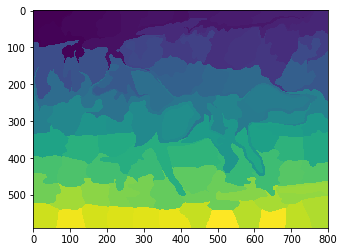

In [191]:
%matplotlib inline
plt.imshow(segments);

In [179]:
scores

{'Knn': [0.88245614035087727, 0.024561403508771916],
 'svml': [0.8403508771929824, 0.0035087719298245281],
 'svmr': [0.85146198830409359, 0.018713450292397661]}

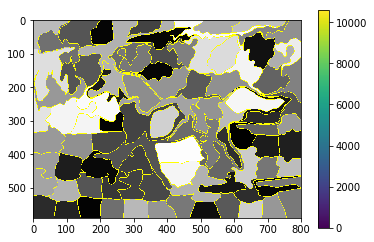

In [264]:


plt.imshow(mark_boundaries(fv[0,segments],segments))
#plt.imshow(np.sqrt(fv[0,segments]),cmap=plt.cm.Greys)
plt.colorbar()

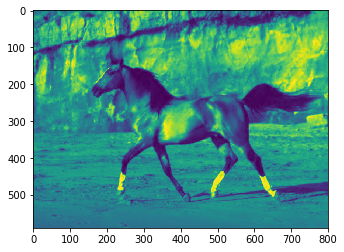

In [242]:
plt.imshow(image[:,:,0])

In [149]:
a.max()

6.9533773909161045e-309

In [197]:
b=np.ones((3,4))

In [198]:
b

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])

In [200]:
b[:,:,0]

IndexError: too many indices for array

In [202]:
b[:,:]=2

In [203]:
b

array([[ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.]])

In [205]:
c=np.ones((3,4))

In [206]:
c

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])

In [209]:
c[2,2]=4
c[1,3]=4

In [265]:
c

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  4.],
       [ 1.,  1.,  4.,  1.]])

In [233]:
compute_polling(b,c)

/Users/mac/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


array([[  0.,  10.,   0.,   0.,   2.],
       [  0.,   2.,   0.,   0.,   2.],
       [  0.,  36.,   0.,   0.,   4.],
       [  2.,   2.,   2.,   2.,   2.],
       [  2.,   2.,   2.,   2.,   2.]])

In [226]:
c.shape

(3, 4)

In [227]:
b.shape

(3, 4)